# Nigeria

## NOTES
Nigeria will be updated soon, so I am only minimally processing it for the time being. Things that should be changed in the new upload
- The duplicates will be removed
- The year-off issue will be resolved

In [1]:
import os, sys, glob, json
os.chdir('../gscd/notebook/')
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [16]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('../data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32735'
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/NG_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #


- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1991	 | NG1991A1 | 31	| nan	| 0	| nan	| 0	|
| 1996	 | NG1996A1 | 37	| nan	| 0	| nan	| 0	|
| 2014	 | NG2014A1 | 37	| NG2014A2	| 774	| nan	| 0	|
----------------------------------------------- #


In [17]:
#FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
#read in username and password
exec(open('/Users/wanders7/Documents/Code/Logins/FDW.py').read())
auth = (username, password)
parameters = {
    'format': 'json',
    'country': 'Nigeria',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionfacts/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

In [18]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting
# a.1) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# a.2) Early in the record the catch-all crop production system is 'all' rather than none. Make these to none-type
df.loc[df['crop_production_system'] == 'all', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'

# ----------------------------------------------- #
#Drop the blank (nan) rows that are duplicates of rows that do have data
df = df[np.isfinite(df.value)]

#Drop duplicate values. This will be fixed in the new data upload. Check carefully after new upload
df = df[~(df[['fnid','crop_production_system','season_year', 'product','indicator','population_group']].duplicated())]
 
# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# # FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([NG_Admin1_1996], axis=0)
PlotAdminShapes(shape_used, label=True)
# # ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 6,248
2,069/2,069 "Area Planted" points are retained.
2,113/2,113 "Quantity Produced" points are retained.
2,066/2,066 "Yield" points are retained.
Current data points: 6,248

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1999 - 2016
5 grain types are found: Maize (Corn), Millet, Rice (Paddy), Sorghum (Mixed), Wheat Grain
1 seasons are found: Wet (09-01)
1 crop production system are found: none
Data sources include:
[1] Federal Ministry of Agriculture and Rural Development, Nigeria --- Agricultural Production Survey, Nigeria
[2] NAERLS, Nigeria --- Annual Agricultural Performance Survey Report, Nigeria
[3] National Agricultural Extension and Research Liaison Services (NAERLS), Nigeria --- FEWS NET AgroMaps, Nigeria
[4] National Agricultural Extension and Research Liaison Services (NAERLS), Nigeria --- Wet-Season Agriculture Performance Survey, Nige

## Nigeria
Nigeria crop seasonal calendar

![FEWS NET](https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-nigeria.png?itok=thouZNER)

![USDA](https://ipad.fas.usda.gov/countrysummary/images/NI/cropcalendar/wafrica_ni_calendar.png)


- comparison of boundaries
![image](../figures/CM_admin_shapes.png)

- In Nigeria, basd on the FEWS NET data, there was three administrative unit changes

| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1991	 | NG1991A1 | 31	| nan	| 0	| nan	| 0	|
| 1996	 | NG1996A1 | 37	| nan	| 0	| nan	| 0	|
| 2014	 | NG2014A1 | 37	| NG2014A2	| 774	| nan	| 0	|

- But the FEWS data only ever uses the 1996 boundaries for FNIDs

In [19]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = NG_Admin1_1996.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #
# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()

In [21]:
# Link admin boundaries ------------------------- #
link_1996, over_1996 = FDW_PD_CreateAdminLink(NG_Admin1_1996,NG_Admin1_1996, 'ADMIN1', 'ADMIN1', prod, epsg)

# Crop specific ratios
link_ratio = FDW_PD_RatioAdminLink(link_1996, prod, over_1996, mdx_pss)

# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

In [23]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "growing year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack_gscd = stack[names]
stack_gscd['gscd_code'] = 'calibrated'
# ----------------------------------------------- #
# Reported FDW data ----------------------------- #
stack_fdw = df[names]
stack_fdw['indicator'] = stack_fdw['indicator'].replace({'Area Harvested':'area','Quantity Produced':'production','Yield':'yield'})
stack_fdw['gscd_code'] = 'reported'
# ----------------------------------------------- #
# Final Processing ------------------------------ #
stack = pd.concat([stack_fdw,stack_gscd], axis=0).reset_index(drop=True)
# No concerns found for grain types
stack['product'] = stack['product'].replace(product_category)
# Calibration of Growing and Harvest year and season
cs = {
    'Wet': {'planting_month':{'9-01':'9-01'},'harvest_month':{'01-01':'01-01'}}}

cy = {}
stack, df, link_ratio = FDW_PD_CaliSeasonYear(stack, df, link_ratio, cs, cy)
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# # ----------------------------------------------- #

# Save data
save_hdf('../data/crop/adm_crop_production_NG.hdf', stack)
save_hdf('../data/crop/adm_crop_production_NG_raw.hdf', df)
save_npz('../data/crop/adm_crop_production_NG_ratio.npz', link_ratio)


../data/crop/adm_crop_production_NG.hdf is saved.
../data/crop/adm_crop_production_NG_raw.hdf is saved.
../data/crop/adm_crop_production_NG_ratio.npz is saved.


../figures/NG_bar_natgrainprod_Wet.png is saved.


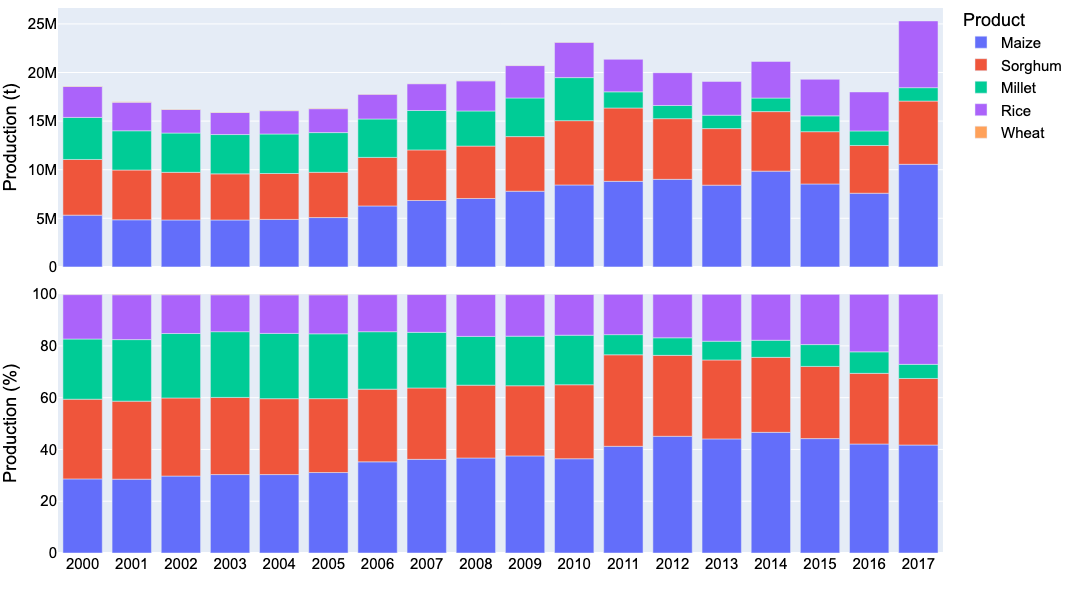

In [26]:
# Bar chart of national grain production
country_iso, country_name = 'NG', 'Nigeria'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Maize','Sorghum', 'Millet','Rice','Wheat']
for season_name in ['Wet']:
    footnote = 'National grain production in %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    if len(sub['year'].unique())<5:
        continue
    fig = PlotBarProduction(sub, year, product_order, footnote, fn_save)
    fig.show()


../figures/NG_line_pay_Maize_Wet.png is saved.


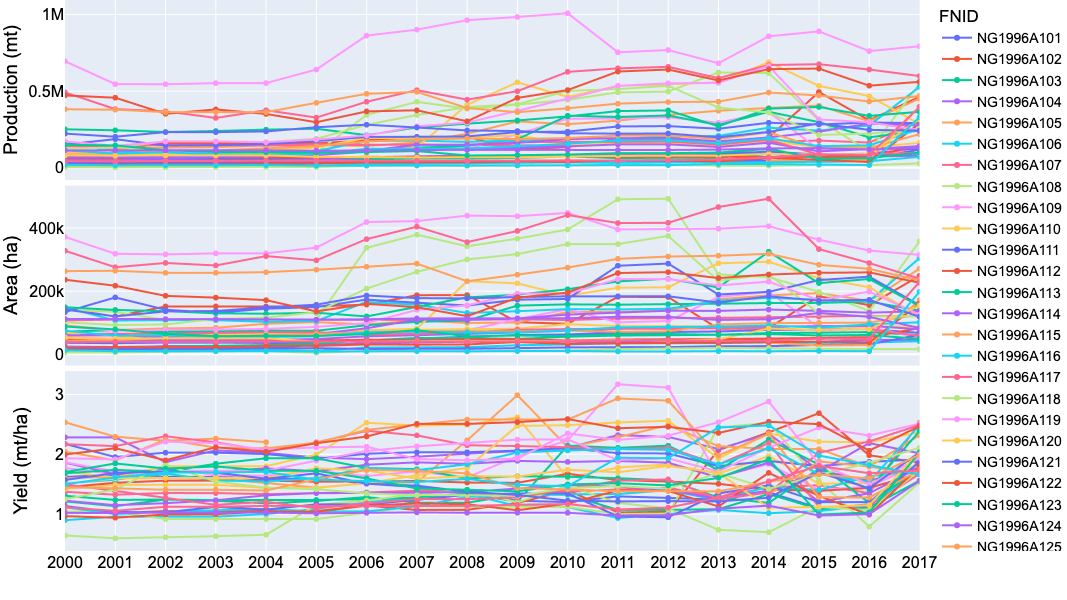

../figures/NG_line_pay_Millet_Wet.png is saved.


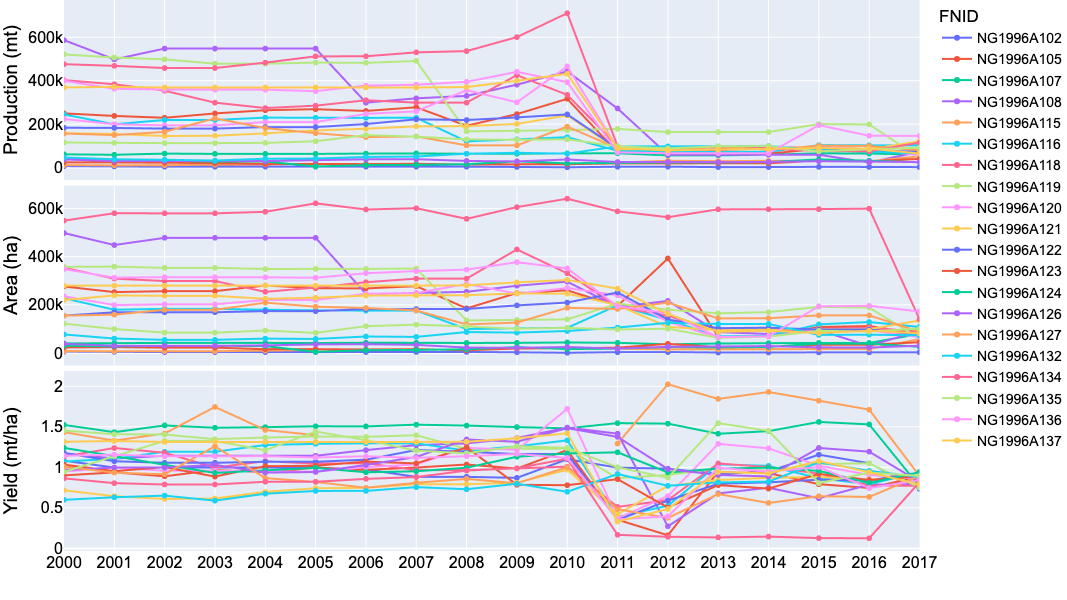

../figures/NG_line_pay_Sorghum_Wet.png is saved.


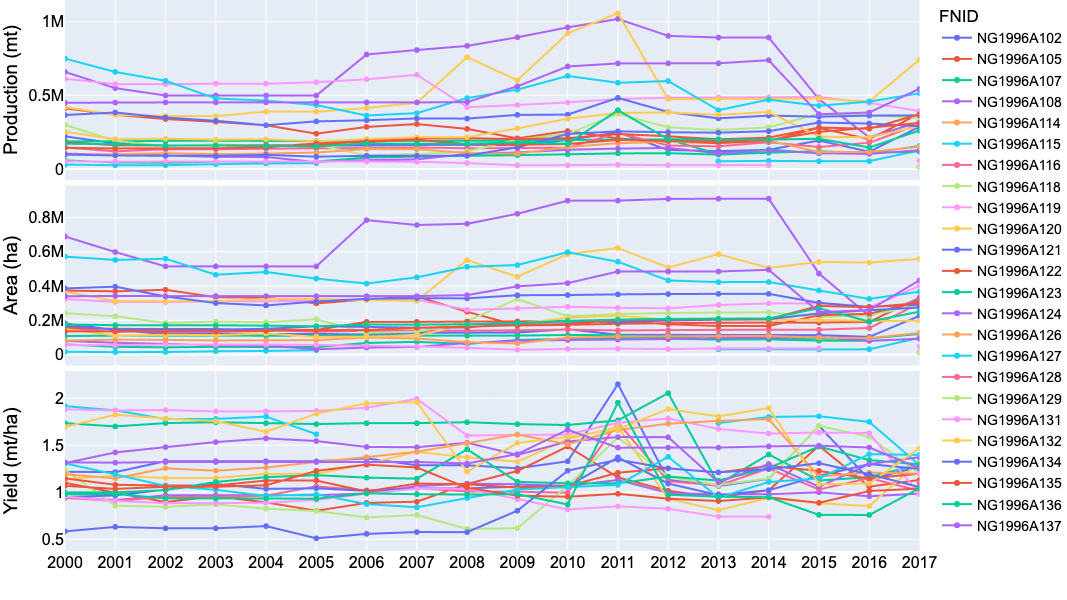

../figures/NG_line_pay_Rice_Wet.png is saved.


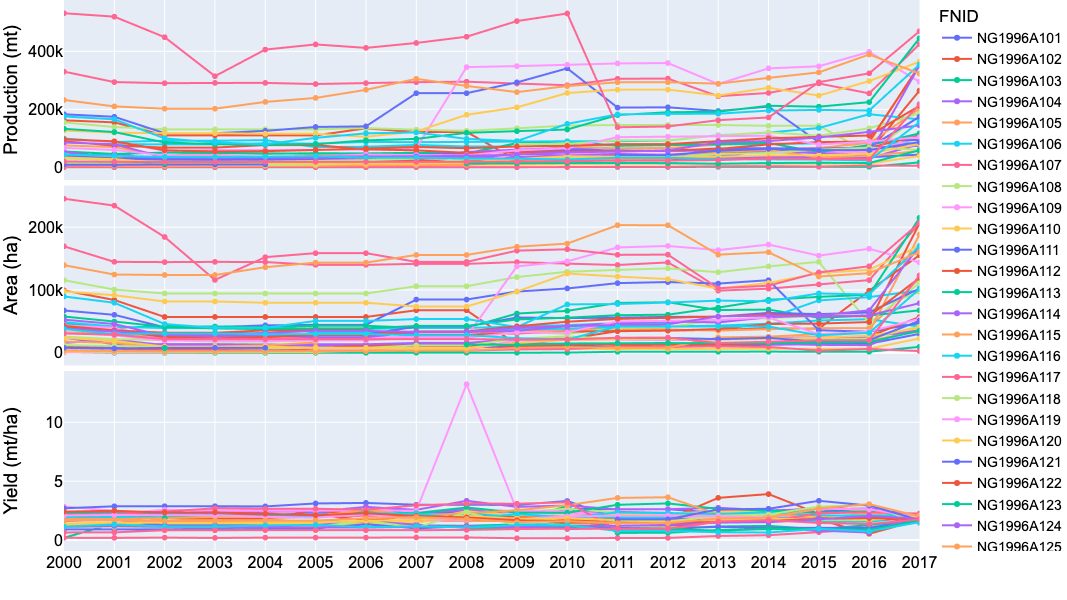

../figures/NG_line_pay_Wheat_Wet.png is saved.


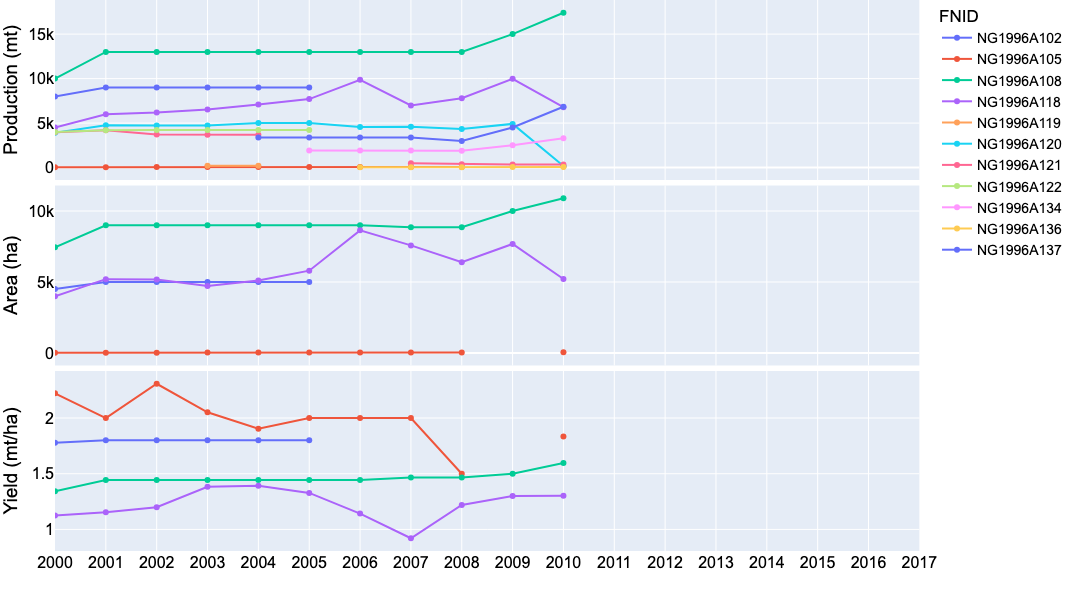

In [27]:
# Lineplot of Production-Area-Yield (PAY) time-series
country_iso, country_name = 'NG', 'Nigeria'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize', 'Wet'],
    ['Millet', 'Wet'],
    ['Sorghum', 'Wet'],
    ['Rice', 'Wet'],
    ['Wheat', 'Wet'],
]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield (PAY) time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    if len(sub['year'].unique())<1:
        continue
    fig = PlotLinePAY(sub, year, footnote, fn_save)
    fig.show()


In [29]:
# Calibrated PAY time-series per FNID
from tools_graphic import PlotLineCropTS
country_iso, country_name = 'NG', 'Nigeria'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
link_ratio = load_npz('../data/crop/adm_crop_production_%s_ratio.npz' % country_iso)
year_all = np.arange(df['year'].min(), df['year'].max()+1)
product_season = [
    ['Maize', 'Wet'],
    ['Millet', 'Wet'],
    ['Sorghum', 'Wet'],
    ['Rice', 'Wet'],
    ['Wheat', 'Wet'],
]

for product_name, season_name in product_season:
    sub = df[
        (df['product'] == product_name) &
        (df['season_name'] == season_name)
    ]
    for fnid in sub['fnid'].unique():
        sub_fps = sub[sub['fnid'] == fnid]
        fn_save = '../figures/crop_calibrated/%s_%s_%s_%s.png' % (country_iso, product_name, season_name, fnid)
        fig = PlotLineCropTS(sub_fps, fnid, product_name, season_name, link_ratio, year_all, fn_save)


../figures/crop_calibrated/NG_Maize_Wet_NG1996A101.png is saved.
../figures/crop_calibrated/NG_Maize_Wet_NG1996A102.png is saved.
../figures/crop_calibrated/NG_Maize_Wet_NG1996A103.png is saved.
../figures/crop_calibrated/NG_Maize_Wet_NG1996A104.png is saved.
../figures/crop_calibrated/NG_Maize_Wet_NG1996A105.png is saved.
../figures/crop_calibrated/NG_Maize_Wet_NG1996A106.png is saved.
../figures/crop_calibrated/NG_Maize_Wet_NG1996A107.png is saved.
../figures/crop_calibrated/NG_Maize_Wet_NG1996A108.png is saved.
../figures/crop_calibrated/NG_Maize_Wet_NG1996A109.png is saved.
../figures/crop_calibrated/NG_Maize_Wet_NG1996A110.png is saved.
../figures/crop_calibrated/NG_Maize_Wet_NG1996A111.png is saved.
../figures/crop_calibrated/NG_Maize_Wet_NG1996A112.png is saved.
../figures/crop_calibrated/NG_Maize_Wet_NG1996A113.png is saved.
../figures/crop_calibrated/NG_Maize_Wet_NG1996A114.png is saved.
../figures/crop_calibrated/NG_Maize_Wet_NG1996A115.png is saved.
../figures/crop_calibrate